In [1]:
import Pkg
Pkg.add("Revise")
Pkg.add("IonSim")
Pkg.add("QuantumOptics")
Pkg.add("StochasticDiffEq")
Pkg.add("DSP")
using PyPlot
using Revise
using IonSim
using QuantumOptics: timeevolution, stochastic, Basis

   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`


In [2]:
Pkg.add("ProgressMeter")
using Distributions # You'll need to add this package!
using ProgressMeter # For a nice progress bar

   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`


In [3]:
C = Ca40([("S1/2", -1/2, "g"),("D5/2", -1/2, "e")])
# Create aliases for the qubit states for easier access
#set_sublevel_alias!(C, Dict("g" => ("S1/2", -1/2), "e" => ("D5/2", -1/2)))

# Define the trap configuration. We'll model a single ion in a linear chain
# with a 1 MHz axial motional frequency.
chain = LinearChain(
    ions=[C],
    comfrequencies=(x=3e6, y=3e6, z=1e6),   
    selectedmodes=(;z=[1]) # We only consider the axial mode of motion
)

# Define the laser that will drive the transition
L = Laser()

# Combine all components into a single Trap object, which represents the full experiment
# This is the main object that holds the entire state of our physical system.
T = Chamber(
    iontrap=chain,
    B=0.37e-3,              # Magnetic field in Tesla
    #δB = 0.1,
    Bhat=ẑ,              # Magnetic field direction
    lasers=[L]
)

polarization!(L, (x̂ - ẑ)/√2)
wavevector!(L, (x̂ + ẑ)/√2);
wavelength_from_transition!(L, C, ("g", "e"), T)
intensity_from_pitime!(L, 4e-6, C, ("g", "e"), T);

ion = ions(T)[1]

ψ0_ion_1 = ion["g"]
ψ0_ion_2 = ion[("S1/2", -1/2)]
ψ0_ion_3 = ionstate(ion, "g")

print(ψ0_ion_1)
mode = IonSim.modes(T)[1]

ψ0_mode_1 = mode[0]
ψ0_mode_2 = fockstate(mode, 0)
ψ0_mode_3 = groundstate(mode)

print(ψ0_mode_1)
ψ₀ = ion["g"] ⊗ mode[0];
print(L)

Ket(dim=2)
  basis: ⁴⁰Ca
 1.0 + 0.0im
 0.0 + 0.0imKet(dim=11)
  basis: VibrationalMode(ν=1.0e6, axis=ẑ, N=10)
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0imλ: 7.291469963176486e-7 m
Δ: 0 Hz
̂ϵ: (x=0.7071067811865475, y=0.0, z=-0.7071067811865475)
k̂: (x=0.7071067811865475, y=0.0, z=0.7071067811865475)
I(t=0): 1.030939867952202e6 W/m²
ϕ(t=0): 0.0 ⋅ 2π


In [4]:
function pulse(T:: Chamber , tspan, pitime, del_intensity)
    # Define the laser that will drive the transition
    L = T.lasers[1]

    # Combine all components into a single Trap object, which represents the full experiment
    # This is the main object that holds the entire state of our physical system.
    
    pi2_time = pitime/2

    res_intensity = intensity_from_pitime(L, pi2_time, T.iontrap.ions[1], ("g", "e"), T)
    actual_intensity = res_intensity + del_intensity

    intensity!(L, (actual_intensity))


    h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);
    return h
end


function experiment(T::Chamber, wait_time, del_intensity)
    pitime = 4e-6
    tspan = 0: 0.1: (wait_time)

    h = pulse(T, tspan, pitime, del_intensity)
    return h
end

# phase!(L, phase_funtion)
# h = hamiltonian(T, timescale=1e-6, rwa_cutoff=Inf);

experiment (generic function with 1 method)

In [5]:
function detuning_intensity1(L::Laser, del_intensity, cnt, t_wait)
    L1 = Laser()

    T1 = Chamber(
        iontrap=chain,
        B=0.37e-3,              # Magnetic field in Tesla
        #δB = 0.1,
        Bhat=ẑ,              # Magnetic field direction
        lasers=[L1]
    )
    polarization!(L1, (x̂ - ẑ)/√2)
    wavevector!(L1, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L1, C, ("g", "e"), T1)
    h1 = experiment(T1, t_wait, del_intensity)
    tspan = 0:0.1:t_wait
    x, y = timeevolution.schroedinger_dynamic(tspan, ψ₀, h1)
    excited_pop1 = expect(ionprojector(T1, "e"), y)
    if(t_wait == 1)
    plot(x, real.(excited_pop1))
    println(real.(excited_pop1[end]))
    println(x)
    end
    return x, real.(excited_pop1[end])

end

detuning_intensity1 (generic function with 1 method)

0.5799696615787058
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.5799696615787058
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.6617554014479998
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
1.2417250630267056
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.5501813661653718
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
1.7919064291920774
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.5073968984676243
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
2.2993033276597017
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.5615787714539876
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
2.8608820991136894
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.5426400483672293
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
3.4035221474809187
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
0.6434517879956075
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
4.046973935476526
[0.0, 0

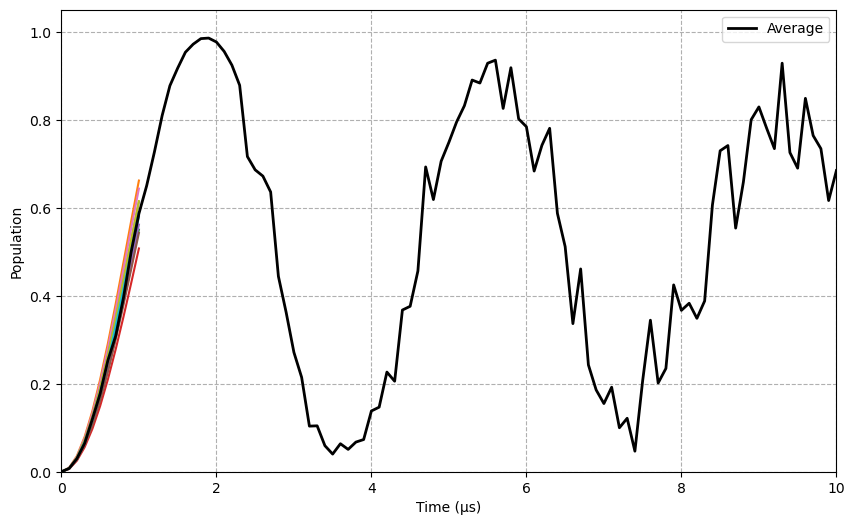

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


In [6]:

figure(figsize=(10, 6))
I_rms_1 = 10
noise_distribution_1 = Normal(0, I_rms_1)
tout, ind = detuning_intensity1(L, 10*1e6, 1, 10)
# println(tout)
# println( ind)
sumB=0.0
ind = []
push!(ind, 0)
for j in 0.1:0.1:10
    sumB=0.0
    for i in 1:1:10
        δB_shot = rand(noise_distribution_1)
        tout1, indi = detuning_intensity1(L, abs(δB_shot*1e5), i, j)
        sumB= sumB + (indi)
        if(j == 1)
        println(sumB)
        println(tout1)
    end
    end
   
    push!(ind, sumB/10)
    
end
println(ind)
plot(tout, ind , label="Average", color = "black", linewidth=2)

xlim(0, 10)
xlabel("Time (μs)")
ylabel("Population")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()
display(gcf())

In [7]:
function detuning_intensity2(L::Laser, del_intensity, cnt, t_wait)
    L1 = Laser()

    T1 = Chamber(
        iontrap=chain,
        B=0.37e-3,              # Magnetic field in Tesla
        #δB = 0.1,
        Bhat=ẑ,              # Magnetic field direction
        lasers=[L1]
    )
    polarization!(L1, (x̂ - ẑ)/√2)
    wavevector!(L1, (x̂ + ẑ)/√2);
    wavelength_from_transition!(L1, C, ("g", "e"), T1)
    h1 = experiment(T1, t_wait, del_intensity)
    tspan = 0:0.1:t_wait
    x, y = timeevolution.schroedinger_dynamic(tspan, ψ₀, h1)
    excited_pop1 = expect(ionprojector(T1, "e"), y)
    
    return x[end], real.(excited_pop1[end])

end

detuning_intensity2 (generic function with 1 method)

Any[0.008281876253889101, 0.0350996610178722, 0.0757336842225141, 0.12314705019685794, 0.1934286812430779, 0.2777432095950589, 0.36618712197302344, 0.48213636205398036, 0.5452985729388765, 0.6260130664079014, 0.7316027862368004, 0.7860211359096616, 0.8545192414474279, 0.9062018963565269, 0.9507653239927775, 0.9753598646681283, 0.9641372908344384, 0.9710740906541004, 0.9457924125556847, 0.8842966402614558, 0.8212796855466811, 0.7588215349475141, 0.6817758148186835, 0.6667869595350148, 0.5221187901160363, 0.41774103970254806, 0.37433519481033584, 0.34636247776595314, 0.2477392945691152, 0.20118348434733413, 0.19208820662683362, 0.12282798566192309, 0.11397318009767284, 0.10193618261203179, 0.08524786193710761, 0.10418240841622486, 0.16926616278647177, 0.1142876112873524, 0.1431773521655157, 0.295254668934939, 0.35838084941890075, 0.40058743866346463, 0.48819006897271394, 0.5513898158158614, 0.5485858347370286, 0.6315240870676301, 0.7182227328261653, 0.7261214223516487, 0.7680775422928328

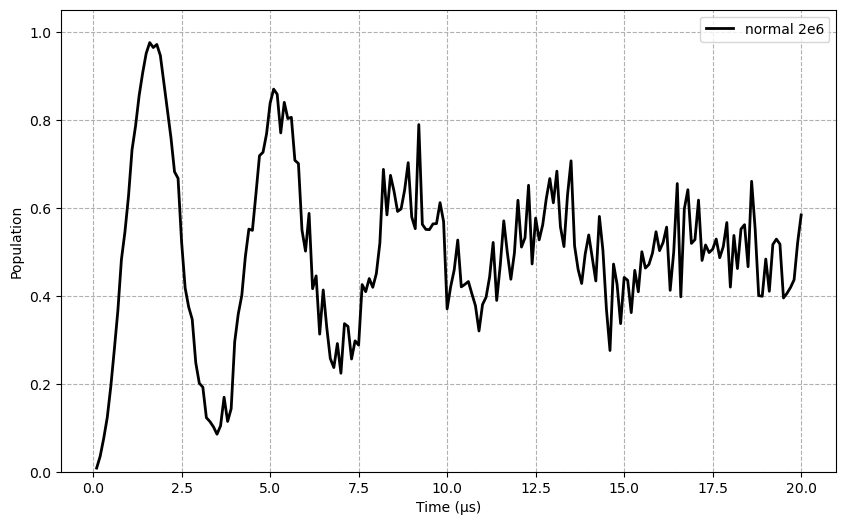

In [45]:

figure(figsize=(10, 6))
I_rms_1 = 2e6
noise_distribution_1 = Normal(0, I_rms_1)
sumB=0.0
tout2 = []
ind = []
for j in 0.1:0.1:20
    sumB=0.0
    x=0
    for i in 1:1:30
        δB_shot = rand(noise_distribution_1)
        x, indi = detuning_intensity2(L, abs(δB_shot), i, j)
        sumB= sumB + (indi)
    end
    push!(tout2, x)
    push!(ind, sumB/30)
end
println(ind)
plot(tout2, ind , label="normal 2e6", color = "black", linewidth=2)

xlabel("Time (μs)")
ylabel("Population")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()
display(gcf())

println(L)

Any[0.0074514784087908745, 0.029146285572397106, 0.06394228864319194, 0.11068381991769156, 0.16755429072904715, 0.24334966090522364, 0.3142436567762429, 0.3958853501186751, 0.4937163507101504, 0.5674891467738106, 0.6325434813581308, 0.7338910707430295, 0.7954367921738181, 0.8600798202754862, 0.9137134023106998, 0.9574195982383196, 0.9824324283901469, 0.991863335661156, 0.9878464484252996, 0.968750160358696, 0.9279462016825459, 0.9031307770125034, 0.8498808992769462, 0.8127252218133061, 0.7585210464380786, 0.6072521159166551, 0.5202749678397579, 0.46197081562312226, 0.31706719640221137, 0.3118996063703393, 0.20799506608516266, 0.15141745591422134, 0.11322458881738065, 0.0971010234846939, 0.05179173758837693, 0.04714230987291119, 0.03142620760564851, 0.0593095275452761, 0.07032390928606724, 0.15042696029661198, 0.11438523404771003, 0.22657661524299755, 0.30416075099835216, 0.4297791822069575, 0.3969895453321344, 0.5356637751337919, 0.522052799656542, 0.6849936526243571, 0.751519204589905

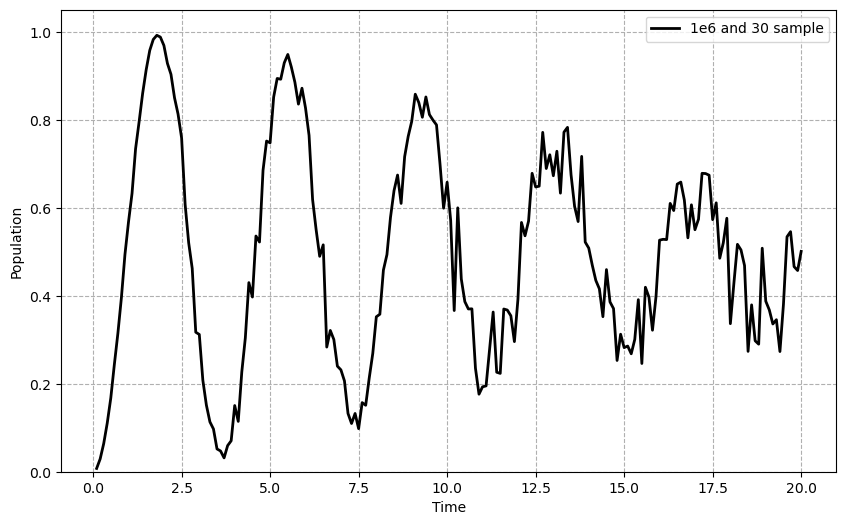

In [46]:

figure(figsize=(10, 6))
I_rms_1 = 1e6
noise_distribution_1 = Normal(0, I_rms_1)
sumB=0.0
tout2 = []
ind = []
for j in 0.1:0.1:20
    sumB=0.0
    x=0
    for i in 1:1:30
        δB_shot = rand(noise_distribution_1)
        x, indi = detuning_intensity2(L, abs(δB_shot), i, j)
        sumB= sumB + (indi)
    end
    push!(tout2, x)
    push!(ind, sumB/30)
end
println(ind)
plot(tout2, ind , label="1e6 and 30 sample", color = "black", linewidth=2)

xlabel("Time")
ylabel("Population")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()
display(gcf())

println(L)

Any[0.007363192838425157, 0.029066823667399808, 0.0646744503105291, 0.1135794721917404, 0.17057688902467608, 0.2430487543503698, 0.3164406835765441, 0.400749205230047, 0.4840765514637937, 0.5721923434968901, 0.656261107724589, 0.7270822612398518, 0.7983918493259259, 0.8599437675802685, 0.9171111222884715, 0.9506942703495249, 0.9760896302259918, 0.9887532384940042, 0.986335898607111, 0.9743918585752231, 0.9384966221297653, 0.8983668918329384, 0.832898548184244, 0.7832520100036128, 0.7028165437892663, 0.6327442191343009, 0.5441343501133716, 0.45682445974678965, 0.38989504351162646, 0.30428916189571176, 0.2360465654910161, 0.1693381866220934, 0.1286265779230402, 0.08254761727918054, 0.056821227305361204, 0.03943801802553928, 0.03323306854429108, 0.05965096745922098, 0.07597412551838321, 0.09500927369388093, 0.1229603915450231, 0.211317166782316, 0.28575921308138086, 0.3790527761594423, 0.4093547055087787, 0.4954395485324931, 0.594919121218084, 0.6424190795301086, 0.6997433049893738, 0.783

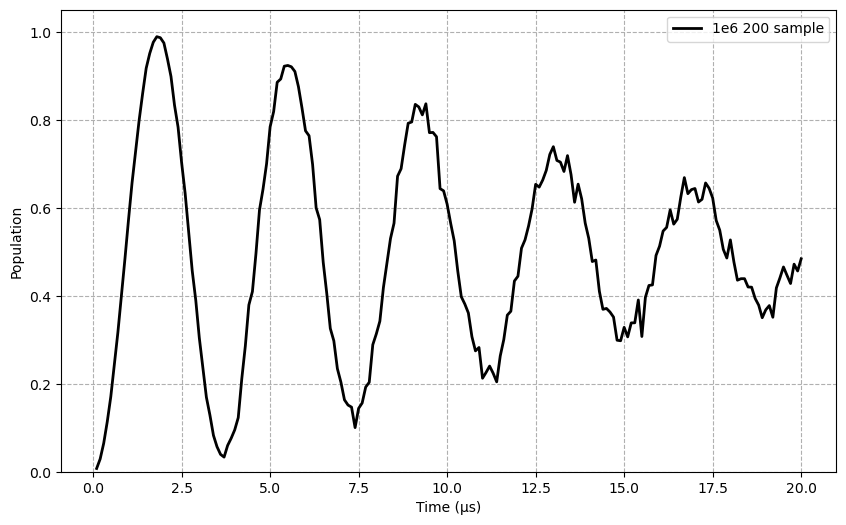

In [47]:

figure(figsize=(10, 6))
I_rms_1 = 1e6
noise_distribution_1 = Normal(0, I_rms_1)
sumB=0.0
tout2 = []
ind = []
for j in 0.1:0.1:20
    sumB=0.0
    x=0
    for i in 1:1:200
        δB_shot = rand(noise_distribution_1)
        x, indi = detuning_intensity2(L, abs(δB_shot), i, j)
        sumB= sumB + (indi)
    end
    push!(tout2, x)
    push!(ind, sumB/200)
end
println(ind)
plot(tout2, ind , label="1e6 200 sample", color = "black", linewidth=2)

xlabel("Time (μs)")
ylabel("Population")
ylim(0, 1.05)
grid(true, linestyle="--")
legend()
show()
display(gcf())

println(L)

In [11]:
    using Pkg
    Pkg.add("GLM")
    Pkg.add("DataFrames")
using DataFrames

   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`


In [14]:
using Pkg
Pkg.add("LsqFit")

   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`


In [ ]:
using LsqFit

# Define the complex model C(t)
# p[1] corresponds to ω₀ (omega_0)
# p[2] corresponds to σ (sigma)
function model_complex(t, p) 
    return exp.(im * p[1] * t) .* exp.(-0.5 * p[2]^2 * t.^2)
end

# Create a wrapper for LsqFit.jl
# This model takes a vector of time points 't' and parameters 'p',
# and returns a real-valued vector where real and imaginary parts are interleaved.
function model_real_interleaved(t, p)
    complex_output = model_complex(t, p)
    # Create a vector to hold interleaved real and imaginary parts
    # It will have twice the length of the input 't' vector
    output = zeros(length(t))
    output[1:1:end] = real(complex_output) # Assign real parts to odd indices
    #output[2:2:end] = imag(complex_output) # Assign imaginary parts to even indices
    return output
end

model_real_interleaved (generic function with 1 method)

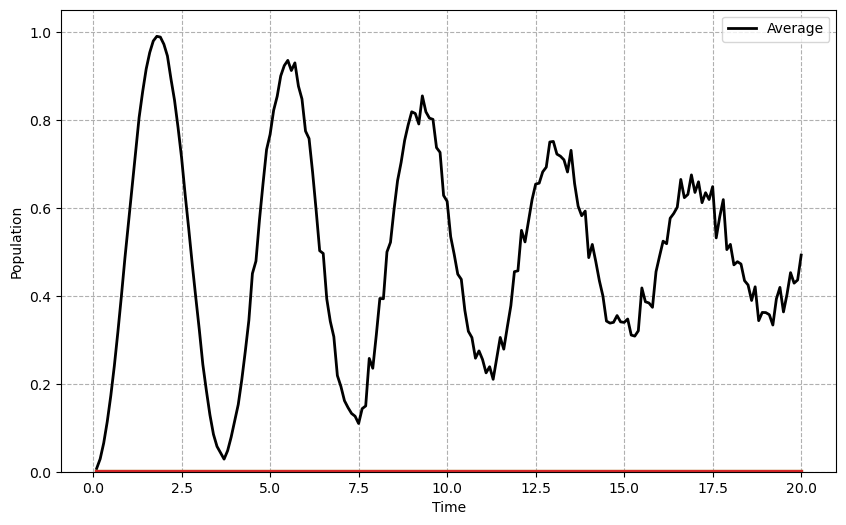

True parameters: [2.5, 0.8]
Fitted parameters: [-192.31767861742287, 136.19121235450385]


In [29]:
# --- 1. Generate Synthetic Data ---

# True parameters we want to recover
p_true = [
    2.5,  # ω₀
    0.8   # σ
]

# Time points
t_data = 0:0.1:10

# Generate the "perfect" complex data using the true parameters
y_complex_perfect = model_complex(t_data, p_true)

# Add some complex Gaussian noise
noise_real = 0.05 * randn(length(t_data))
noise_imag = 0.05 * randn(length(t_data))
y_complex_noisy = y_complex_perfect + (noise_real + im * noise_imag)

# Prepare the noisy data for fitting by interleaving its real and imaginary parts
y_real_interleaved = zeros(2 * length(t_data))
y_real_interleaved[1:2:end] = real(y_complex_noisy)
y_real_interleaved[2:2:end] = imag(y_complex_noisy)


# --- 2. Perform the Fit ---

# Initial guess for the parameters [ω₀, σ]
p0 = [2.0, 1.0]

# Use curve_fit to find the best parameters
fit = curve_fit(model_real_interleaved, tout2, ind, p0)

# The fitted parameters are in fit.param
p_fit = fit.param
println("True parameters: ", p_true)
println("Fitted parameters: ", p_fit)


# --- 3. Visualize the Results ---

# Generate the fitted curve using the complex model
y_fit = model_complex(tout2, p_fit)

# Plot the real parts
#plot(t_data, real(y_complex_noisy), seriestype=:scatter, label="Noisy Data (Real)", legend=:topright)
plot(tout2, real(y_fit), linewidth=3, label="Fitted Model (Real)")

# Plot the imaginary parts
# plot!(t_data, imag(y_complex_noisy), seriestype=:scatter, label="Noisy Data (Imag)")
# plot!(tout2, imag(y_fit), linewidth=3, label="Fitted Model (Imag)")

# title!("Fitting a Complex Decoherence Model")
# xlabel!("Time (t)")
# ylabel!("C(t)")
display(gcf())

In [30]:
using LsqFit

# p[1] = ω₀
# p[2] = σ
function complex_model(t, p)
    ω₀ = p[1]
    σ = p[2]
    
    # Use broadcasting (.@) to apply the function to each element of t
    return @. exp(im * ω₀ * t) * exp(-0.5 * σ^2 * t^2)
end

complex_model (generic function with 1 method)

In [31]:
# This is the function we will pass to curve_fit
function fit_model(t, p)
    # Get the complex predictions
    predictions_complex = complex_model(t, p)
    
    # Stack the real and imaginary parts into one long vector
    return [real(predictions_complex); imag(predictions_complex)]
end

fit_model (generic function with 1 method)

In [ ]:
using LsqFit
using Random # for noise

# --- 1. Define Models ---

# p[1] = ω₀
# p[2] = σ
function complex_model(t, p)
    return @. exp(im * p[1] * t) * exp(-0.5 * p[2]^2 * t^2)
end

function fit_model(t, p)
    predictions_complex = complex_model(t, p)
    return [real(predictions_complex); imag(predictions_complex)]
end

# --- 2. Generate Sample Data ---
true_params = [
    10.0,  # ω₀
    0.5    # σ
]

t_data = 0:0.1:10.0
C_data_clean = complex_model(t_data, true_params)

# Add some complex noise
Random.seed!(123)
noise_real = 0.05 .* randn(length(t_data))
noise_imag = 0.05 .* randn(length(t_data))
C_data_noisy = C_data_clean .+ (noise_real .+ im .* noise_imag)

# --- 3. Prepare Data for Fitting ---
# Create the stacked y-vector that matches our fit_model's output
y_data_stacked = [real(C_data_noisy); imag(C_data_noisy)]

# --- 4. Run the Fit ---
# Initial guess for parameters p = [ω₀, σ]
p_guess = [9.0, 0.8]

# Run the curve_fit function
# We pass t_data as the x-data and the stacked vector as the y-data
fit_result = curve_fit(fit_model, t_data, y_data_stacked, p_guess)

# --- 5. View Results ---
println("Fit converged: ", fit_result.converged)
println("Fitted Parameters: ", coef(fit_result))
println("True Parameters:   ", true_params)

plot()
# You can get R-squared, residuals, etc. from the fit_result object
# Note: The residuals will be for the *stacked* vector
# println("\nR-squared: ", r2(fit_result))

Fit converged: true
Fitted Parameters: [10.012823490801303, 0.49324021721642153]
True Parameters:   [10.0, 0.5]


In [44]:
using LsqFit

# 1. Define your analytic model (from our last conversation)
# p[1] = ω₀
# p[2] = σ
@. real_model(t, p) = cos(p[1] * t) * exp(-0.5 * p[2]^2 * t^2)

# --- ASSUME YOUR DATA IS LOADED ---
# ind = [...]    # Your x-values (time)
# tout2 = [...]  # Your y-values (the real part of C(t))
# ---------------------------------

# 2. Make an initial guess for the parameters [ω₀, σ]
# !! This is the most important part. You must provide a guess.
# Try to guess ω₀ by looking at the frequency of your data.
# Guess σ to be a small positive number.
p_guess = [1.0, 0.5]  # <--- YOU WILL LIKELY NEED TO CHANGE THIS

# 3. Run the fit
fit = curve_fit(real_model, tout2, ind, p_guess)

# 4. Get the best-fit parameters
fit_params = coef(fit)

println("Fit converged: ", fit.converged)
println("Fitted ω₀: ", fit_params[1])
println("Fitted σ:  ", fit_params[2])

Fit converged: false
Fitted ω₀: -0.0001173262010282563
Fitted σ:  0.6126295552123592


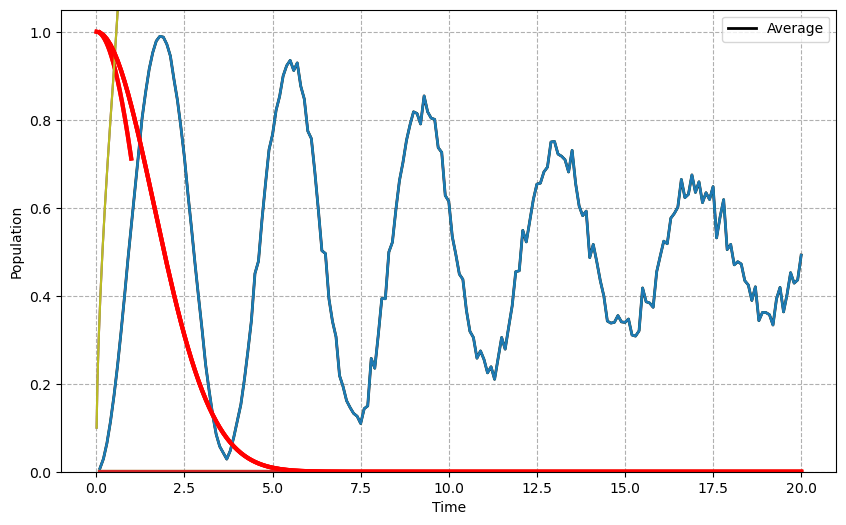

In [43]:
# 5. Generate a smooth line for the fitted model
# Create a dense range of x-values from the start to end of your data
t_fit = range(minimum(tout2), maximum(tout2), length=200)

# Calculate the y-values using your *fitted* parameters
y_fit = real_model(t_fit, fit_params)

# 6. Plot everything
plot(
    tout2, 
    ind, 
    
)

plot(
    t_fit, 
    y_fit, 
    
    linewidth=3, 
    color=:red, 
    label="Fitted Model"
)

display(gcf())

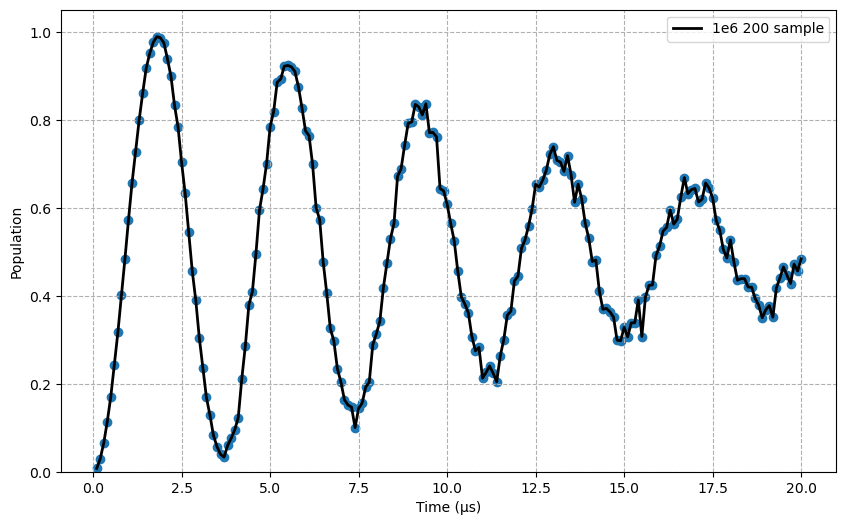

In [48]:
df = DataFrame(x = tout2)
df.y = ind  
PyPlot.scatter(df.x, df.y, label="data")
display(gcf())

In [78]:
Pkg.add("GLM")
Pkg.add("Statistics")
Pkg.add("StatsBase")

   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
   Installed StatsBase ─ v0.34.7
    Updating `C:\Users\jewoo\.julia\environments\v1.10\Project.toml`
  [2913bbd2] + StatsBase v0.34.7
    Updating `C:\Users\jewoo\.julia\environments\v1.10\Manifest.toml`
  [2913bbd2] ↑ StatsBase v0.34.6 ⇒ v0.34.7
Precompiling project...
   5017.4 ms  ✓ StatsBase
  1 dependency successfully precompiled in 7 seconds. 462 already precompiled.
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version. Otherwise, loading dependents of this package may trigger further precompilation to work with the unexpected version.


sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


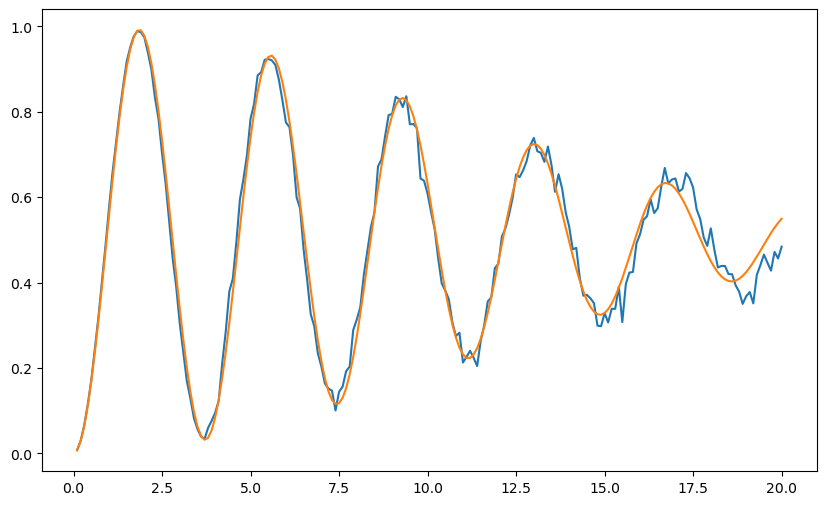

a1 = 1.684699833899311
a2 = 0.004716466843012906


In [80]:

figure(figsize=(10, 6))
plot(df.x, df.y, label="data")
f(x, p) = 1/2 .* (1 .- cos.(p[1] .* x) .* exp.(-p[2] .* x.^2))

# initial guess for [a, b]
p0 = [1, 1.0]

# fit the model to your data
fit = curve_fit(f, df.x, df.y, p0)

println("a1 = ", fit.param[1])
println("a2 = ", fit.param[2])
#println("\nR-squared: ", r2(fit))
# plot data vs fitted curve
plot(df.x, f(df.x, fit.param), label="fit")





display(gcf())


In [92]:
 residuals = fit.resid

 println(residuals)
    # Calculate the sum of squares of residuals (SSR)
    SSR = sum(abs2, residuals)

    # Calculate the total sum of squares (SST)
    # You need the mean of the original ydata for this
    mean_y = mean(tout2)
    SST = sum(abs2, tout2 .- mean_y)

    # Calculate R-squared
    R2 = 1 - (SSR / SST)

    println("R-squared: $R2")

[-0.00026117742530532354, -0.0008631726148044389, -0.0019768158920643875, -0.003987939116681757, -0.003040212290115446, -0.008181308430154882, -0.00679091539850496, -0.011011813298857587, -0.011242271582568186, -0.01563105836329215, -0.01773595847927123, -0.010694465445960977, -0.010457961604295352, -0.008809095901900599, -0.012904876172502688, -0.005033711878034475, -0.0017419749686391484, 0.0007347321205445345, 0.0043578373467320075, 0.0035870581699670723, 0.013260800456195598, 0.014462791349650672, 0.029459477271811196, 0.01857960541674486, 0.03020548924755273, 0.025186600787015623, 0.034596220490931806, 0.040876861554868804, 0.02726907707963011, 0.03512457846199568, 0.030605935438362153, 0.03158895469091608, 0.015443987492619021, 0.015102524137606252, 0.006102801588584679, 0.0013687452046518903, -0.0013880217490918542, -0.023446577505167918, -0.022307204102531217, -0.011368917152738495, 0.0022173923471417306, -0.03430955248255957, -0.04818647071571047, -0.07397506992492225, -0.0318